# Assignment 2:  Motif finding


## Part 1:  Motif discovery using Gibbs sampling

In class we described the Gibbs sampling approach to motif finding.  Implement the algorithm and apply it to the sequences provided as the fasta file associated with this assignment, available via Canvas.  Run your algorithm and experiment with different motif lengths and other parameters of the algorithm.  Do you obtain consistent results across different runs of your code?  For scoring a motif use relative entropy.
The data you were given is taken from ChIP-seq experiments for the transcription factor USF1.  Compare the motif you found with the motif provided in the [CIS-BP database](http://cisbp.ccbr.utoronto.ca/) and comment on the similarity in terms of the pattern of nucleotides.  What is the relative entropy score of the final motif you obtained?

Note that the provided file contains a large number of sequences, which can make it difficult to test your code.
When developing your code, test it first on a toy dataset that you create by embedding a motif in a small set of short sequences.  Demonstrate that your algorithm indeed works on this small dataset.  We suggest to then evaluate your code on a sample of the provided sequences.

The motif found by your Gibbs sampler should be returned as a list-of-lists or two dimensional NumPy array, where each element in the list is a list of length four that corresponds to a position in the motif, and is a probability distribution over the nucleotides in that position, providing the probabilities for A, C, G, and T, respectively.

For example, the list 
```Python
[[0.5, 0, 0, 0.5], [0, 0.5,0.5, 0]]
```
represents a motif of length 2, whose first position contains either an A or T, each with probability 0.5, and its second position contains either a C or a G, each with probability 0.5.

In [1]:
# I switched the order of the motif, I like nucleotide by positions, instead of position by nucleotide.
# it keeps my code more consistent

In [2]:
# Nucleotide Order
nucleotide_order = 'ACGT'
nucleotide_index = {n: i for i, n in enumerate(nucleotide_order)}
nucleotide_index

{'A': 0, 'C': 1, 'G': 2, 'T': 3}

In [32]:
import random
import numpy as np

#%% Generate Fake Data
# Generate num_string (t) x DNA_lenght (l)
t, l = 23, 41

def generate_same_dna(length, nucleotide='c'):
    return ''.join(nucleotide for _ in range(length))

def generate_random_dna(length):
    return ''.join(random.choice('atgc') for _ in range(length))

def generate_dna_list(R, C, random_flag=True):
    if random_flag:
        return [generate_random_dna(C) for _ in range(R)]
    else:
        return [generate_same_dna(C) for _ in range(R)]


dna = generate_dna_list(t, l)

# insert a Kmer into each of the strings of len K
if True:
    random_kmer = 'AGTGTATT'
    insertion_index = [random.choice(np.arange(l-len(random_kmer))) for _ in range(t)]

    for i in range(len(insertion_index)):
        dna[i] = dna[i][:insertion_index[i]] + random_kmer + dna[i][insertion_index[i]+len(random_kmer):]


print(dna)

['aagccgcttttctggtaaacgccAGTGTATTactgcccaca', 'cgcaatctcagAGTGTATTtgtttgcaagtcaggcgactgc', 'cagaaggggacaccgcagtAGTGTATTgctaaccgaattgg', 'aatggacaagaagggggacAGTGTATTggtgcggagaatca', 'tAGTGTATTtggtgacgcatccttgcattcaattggctctc', 'catAGTGTATTctcgggtaaagccccgaatgaaccgagtct', 'tagttacAGTGTATTgtgctctggtggagcgtgacaacacc', 'accctgtcttgcttggttgcgccgAGTGTATTgcggaagca', 'taccaggagagggtcaAGTGTATTtctaacctggatgatag', 'tgtgtatcgtcggtctcgtcggAGTGTATTaggtacattgc', 'tcggatatgccacgAGTGTATTcctgccttctttatggtta', 'agcAGTGTATTgctgttccccagtgtagttttccgtattgt', 'gagcattgtcttAGTGTATTaagaaaggaagtcgtgacgta', 'cactaattgcagccagggtgggccgAGTGTATTttctccta', 'ttggctgtcaagtagcaggcaAGTGTATTtgcctcactcac', 'ctcaAGTGTATTttaatatgccttgaacctcgatgtacacg', 'tctttacagcgactatggattgtgggAGTGTATTtacccat', 'cggtaagccaaccgttgaaaAGTGTATTaggcgtcccccag', 'tattctattgcgatagcacggccagatgcAGTGTATTgtgg', 'gtgttttgaatgttaaaatggcgaAGTGTATTtttgaccgg', 'cgattttgtggattgcagttgcgaAGTGTATTttcagatcc', 'tatctcctgAGTGTATTtgtaaagtacgaagactgatgtgc', 'ttgttatc

In [33]:
from Bio import SeqIO

#%% Code Development
fasta_path = r'database\usf1_short.fasta'
def load_data(file_path):
    dna = []
    for record in SeqIO.parse(fasta_path, 'fasta'):
        dna.append(str(record.seq))

    t = len(dna) # num of seq
    l = len(dna[0]) # length of string

    assert np.all([l == len(dna[i]) for i in range(t)]), 'sequences are not all the same length'

    return dna, t, l

# dna, t, l = load_data(fasta_path)

def get_counts_matrix(seq:list) -> np.array: # num_nuc x n
    counts = np.zeros([len(nucleotide_index), len(seq[0])])
    for i_s, s in enumerate(seq):
        for i_n, n in enumerate(s):
            counts[nucleotide_index[n.upper()], i_n] += 1
    return counts

counts = get_counts_matrix(dna)
# print(counts)

assert counts.shape == (4, l), 'I hope Im smart'

def get_profile_matrix(counts):
    pscounts = counts + 1 # pseudo counts
    sums = np.sum(pscounts, axis=0)
    profile = pscounts/sums
    return profile

profile = get_profile_matrix(counts)
# print(profile)

assert np.all(np.isclose(np.sum(profile, axis=0), np.ones(l), atol=0.001)), 'they arent probabilities'

def calc_probailities(kmers: list, profile: np.array):
    probabilities = []
    for mer in kmers:
        prob = 1
        for i, n in enumerate(mer):
            prob *= profile[nucleotide_index[n.upper()], i]
        probabilities.append(prob)
    return probabilities

probs = calc_probailities([dna[0]], profile)

print(f'probablility of one of the seq: {probs}') # I had a feeling this would be very tiny in testing, I cant think of a good test


def calculate_entropy_matrix(profile):
    p = 0.25 # assumption: all base pairs appear at the same frequency
    RE = np.zeros(len(profile))
    for i in range(len(profile)):
        RE[i] = np.sum(profile[:, i] * np.log2(profile[:, i]/p))
    return RE

RE = calculate_entropy_matrix(profile)

print(f'Relative entropy: {np.sum(RE)}')


probablility of one of the seq: [np.float64(2.1314517708414622e-23)]
Relative entropy: 0.5272066363390592


In [34]:
from typing import Union
def gibbs_motif(file_path: Union[str, list], length, iterations) -> np.array:
    """
    Discover motifs using the Gibbs sampling approach.
    
    parameters:
    file_name - fasta file containing the sequences
    length - the length of the motif
    iterations - the number of iterations to run the algorithm

    Returns a motif as a list of lists or two dimensional NumPy array
    """
    # initialize params
    best_entropy = 0 
    best_motif = None
    k = length

    # Load in dna sequences from fasta
    if type(file_path) == str:
        dna, t, l = load_data(file_path)
    else: # for debugging so I can throw in made up sequences
        dna = file_path
        t = len(dna)
        l = len(dna[0])

    # select one random kmer from each dna sequence -> motif
    motif_idx = [random.choice(np.arange(l-k)) for _ in range(t)]
    motif = [seq[motif_idx[i]:motif_idx[i]+k] for i, seq in enumerate(dna)]

    # begin loop
    for iter in range(iterations):
        # select an random index in arange(t) as withheld dna -> withheld_index, withheld_dna, motif
        withheld_index = random.choice(np.arange(t))
        withheld_dna = dna.pop(withheld_index)
        withheld_motif = motif.pop(withheld_index)
        assert len(dna) == t-1, 'we have messed up witheld a dna'
        assert len(motif) == t-1, 'we have messed up witheld a motif'

        # calculate count matrix -> counts
        counts = get_counts_matrix(motif)

        # calculate profile -> profile
        profile = get_profile_matrix(counts)
        assert profile.shape == (4, k), 'I hope Im smart'

        # calculate probablity of all withheld kmers
        withheld_kmers = [withheld_dna[i:i+k] for i in range(l-k)]
        probs = calc_probailities(withheld_kmers, profile)

        # select new kmer to be added to motif
        new_kmer = random.choices(withheld_kmers, weights=probs, k=1)[0]
        dna.insert(withheld_index, withheld_dna)
        motif.insert(withheld_index, new_kmer)
        assert len(dna) == t, 'we dont have all the sequences'
        assert len(motif) == t, 'we dont have all the motifs'

        # calculate relative entropy of the motif
        RE = calculate_entropy_matrix(profile)
        entropy = np.sum(RE)

        # save best motif
        if entropy > best_entropy:
            best_entropy = entropy
            best_motif = profile

    return best_motif

In [56]:
motif = gibbs_motif(dna, 10, 5000)
print('Motif: ')
print(motif)

def convert_motif_to_seq(motif):
    sequence = ''
    max_indexs = np.argmax(motif, axis=0)
    for i in max_indexs:
        sequence += nucleotide_order[i]
    return sequence

found_seq = convert_motif_to_seq(motif)
print('Found Sequence: ')
print(found_seq)
print('True Sequence: ')
print(random_kmer)

Motif: 
[[0.03846154 0.03846154 0.03846154 0.03846154 0.88461538 0.03846154
  0.03846154 0.15384615 0.11538462 0.07692308]
 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
  0.07692308 0.11538462 0.26923077 0.26923077]
 [0.88461538 0.03846154 0.88461538 0.03846154 0.03846154 0.03846154
  0.03846154 0.30769231 0.26923077 0.26923077]
 [0.03846154 0.88461538 0.03846154 0.88461538 0.03846154 0.88461538
  0.84615385 0.42307692 0.34615385 0.38461538]]
Found Sequence: 
GTGTATTTTT
True Sequence: 
AGTGTATT


Test Probablility


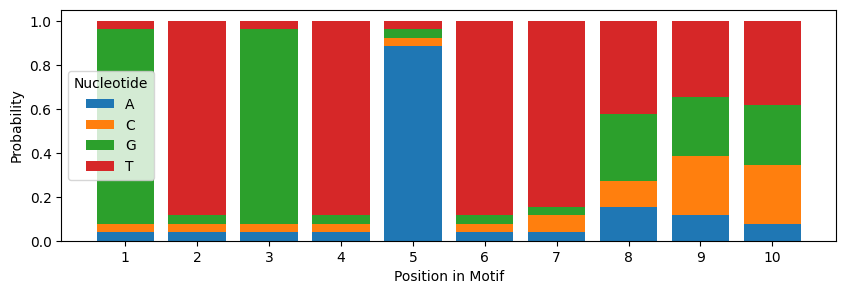

In [57]:
import matplotlib.pyplot as plt

def display_logo(motif): # this is not a logo lmao
    motif_length = motif.shape[1]
    fig, ax = plt.subplots(figsize=(10, 3))

    bottom = np.zeros(motif_length)
    for i, nucleotide in enumerate(nucleotide_order):
        ax.bar(range(motif_length), motif[i], bottom=bottom, label=nucleotide)
        bottom += motif[i]

    ax.set_xticks(range(motif_length))
    ax.set_xticklabels(range(1, motif_length + 1))
    ax.set_xlabel('Position in Motif')
    ax.set_ylabel('Probability')
    ax.legend(title='Nucleotide')
    plt.show()

print('Test Probablility')
display_logo(motif)

Found Sequence: 
GGTCACGTGACC
Found Probablility


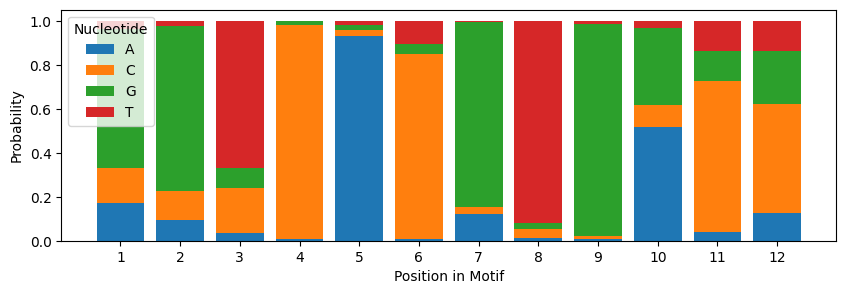

In [59]:
seq = []
for _ in range(1):
    motif = gibbs_motif(fasta_path, 12, 10000)

    found_seq = convert_motif_to_seq(motif)
    seq.append(found_seq)

print('Found Sequence: ')
for seq in seq:
    print(seq)

print('Found Probablility')
display_logo(motif)

Actual Probablility


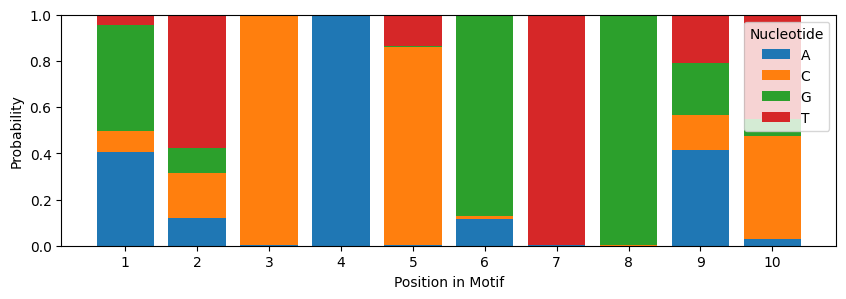

In [ ]:
# From https://cisbp.ccbr.utoronto.ca/data/3_00/DataFiles/PWMs/Files/M02996_3.00.txt
# USF1 M02996_3.00
actual_motif = np.array([
    [0.407475169890225,	0.0904338734971249,	0.456089911134344,	0.0460010454783063],
    [0.119909502262443,	0.193873999303864,	0.111033762617473,	0.57518273581622],
    [0.00180831826401447,	0.996081977094635,	0.00210970464135021,	0.0],
    [0.996081977094635,	0.000301386377335744,	0.00301386377335744,	0.000602772754671489],
    [0.00103977125032493,	0.859110995580972,	0.00467897062646218,	0.135170262542241],
    [0.117833553500661,	0.00898282694848085,	0.873183619550859,	0.0],
    [0.00241036456764086,	0.0,	0.00180777342573064,	0.995781862006629],
    [0.000904431715405487,	0.00211034066927947,	0.996382273138378,	0.000602954476936991],
    [0.413125,	0.150875,	0.228,	0.208],
    [0.0301057770545159,	0.446433414700298,	0.0735014917276919,	0.449959316517494] ,
]).T

print('Actual Probablility')
display_logo(actual_motif)


In [ ]:
#%% Observations

# Gibbs is a stochastic algorithm so I do not always find the same domain. 
# In fact if I only look at the most likely found nucelotides in each position it is normally
# off in quite a few positions. This occurs both in the real data and my simulated data.
# However, if I sample it a few time I will normally get the correct domain at least one. 
# Increase the number of iterations seems to get me to the correct domain more frequenctly.
# Change the length of the kmer is interesting, if it is less then the domain size it seems to find
# sub samples of the domain, this works well for my fake data but is really hard to tell with the real data
# for kmers larger then the domain size it seems to find the domain as part of the motif. Really interestingly in
# in the test data the sequence will have very high probability and the random additional points will be random. 
# Using this observation you can often see the correct motif in the real data and it seems to happen more consistently
# with a large kmer then the domain. to spot the domain eaily, look for the orange and blue bars at 3 and 4 and the red and green bars
# at positions 7 and 8. 

## Part 2:  a review of biology terms

Answer the following questions (up to a paragraph for each question):

* Transcription factors have a strong impact on many biological processes.  Explain how!  How many transcription factors are coded by the human genome?  Compare that to the total number of genes.  Wikipedia is a good source ( [article](https://en.wikipedia.org/wiki/Transcription_factor) ), as is the following article:  [The Human Transcription Factors
](https://www.cell.com/cell/fulltext/S0092-8674(18)31257-1).
  

There are ~ 1,600 transcription factors and roughly ~20,000 protein coding genes (probably a lot more not protein coding cause only 40% of RNA not including rRNA and tRNA are mRNA). This means transcription factors are a one to many mapping for genes. This causes them to alter the state of the cell and for epigentics that regulate the binding of these genes to play a major role. In my research we look at glucocorticoids and glucocorticoid receptor (GR), and the down stream RNA production of a gene called DUSP1. GR bind to GREs and these are sprinkled throughout the genome and can play a major role in the anti-inflammatory signalling.

* What makes the motif finding problem difficult?  How does the biological technique of ChIP-seq assist in that when it comes to determining the binding sites of transcription factors?

Motif finding is like finding a needle in a string haystack. There ~ 3 billion base pairs in the human genome, and this is computationally infeasible to go look for pattern in this letter soup. ChIP-seq is a way to shorten the seach space by using biology and chemistry to pull down only sequences that bind to the transcription factor of interest. This makes it very possible to look for patterns in this subset. 

* What is a promoter and enhancer, and how they are relevant to the topic of motif finding?

Promoter and enhancers are awesome! Transcription is a 3D process. There is bending of the template strand that needs to occur, and many transcription factors like general transcription factors and mediator proteins that need to bind for transcription to occur. Promotors and enhancer and promoters are where these proteins bind and allow for transcription to occur. Finding these are biologically useful and are a great task for motif finding. This can be a difficult task because enhancers can often work from a large genomic distance. This is where the fun of DNA topology start to take effect and where structures like chromatin and TAD domains start to play a major role.

* In class we also described an algorithm called *RandomizedMotifSearch*.  Why do you expect Gibbs sampling to perform better?

Just from running Gibbs many times, the seach space seems to be very textures. Having many peak and local maxima. The RandomMotifSearch algorithm will very quickly converge to one of these local maxima but will not make its way to the highest peak, this is because it is greedy and short sighted. This is why the randomness of Gibbs is so useful and allow the algorithm to more frequencly find the correct motif.

### Submission

Submit your assignment as a Jupyter notebook via Canvas.  

### Grading 

Here is what the grading sheet will look like for this assignment. 

```
Grading sheet for assignment 2
- Correctness of your Gibbs sampler, including test on toy data (70 pts)
- Results and analysis (15 pts)
- Biology questions (15 pts)
```
